In [1]:
import pandas as pd
# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


# feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from textblob import TextBlob

# gensim
import gensim
from gensim import corpora, models, similarities, matutils

# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB


import sklearn.metrics as mt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler, MinMaxScaler,MaxAbsScaler
import string

In [2]:
#Importing libraries
import re

## Connect to DataBase

In [3]:
import pandas as pd
from pymongo import MongoClient
import pandas as pd
# This connects us to the "tripAdvisor_london_restaurant" database, and the "collection" [think table] restaurant_reviews 
# in that database
client = MongoClient()
db = client.tripAdvisor_london_restaurant
collection = db.restaurant_reviews

cursor = db.restaurant_reviews.find({}, {'_id':0,'id':0,'index':0})
df = pd.DataFrame(data=list(cursor))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288966 entries, 0 to 288965
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   name      288966 non-null  object
 1   rating    288966 non-null  object
 2   comments  288966 non-null  object
 3   users     288966 non-null  object
 4   summary   99728 non-null   object
 5   info      134377 non-null  object
 6   loc       288966 non-null  object
dtypes: object(7)
memory usage: 15.4+ MB


### Data Preprocessing

In [4]:
df["name"] = df["name"].replace(r'([\d]+)\.','',regex=True)

In [5]:
df["sıralama"] = df["name"].str.extract('([\d]+)\. ', expand=False)

In [6]:
df = df.sort_values(by=["sıralama"])

In [7]:
df = df.drop(columns=["sıralama"]) # 24103
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288966 entries, 0 to 288965
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   name      288966 non-null  object
 1   rating    288966 non-null  object
 2   comments  288966 non-null  object
 3   users     288966 non-null  object
 4   summary   99728 non-null   object
 5   info      134377 non-null  object
 6   loc       288966 non-null  object
dtypes: object(7)
memory usage: 17.6+ MB


In [8]:
df = df.drop_duplicates(subset =["name","rating","comments"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159150 entries, 0 to 288652
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   name      159150 non-null  object
 1   rating    159150 non-null  object
 2   comments  159150 non-null  object
 3   users     159150 non-null  object
 4   summary   52641 non-null   object
 5   info      70805 non-null   object
 6   loc       159150 non-null  object
dtypes: object(7)
memory usage: 9.7+ MB


In [9]:
df.name.nunique()

2815

In [10]:
#df = df.drop(columns=["users"])

In [11]:
df = df.reset_index()

In [12]:
val = df["loc"].to_list()

new =[]

for v in val:
    if(len(v)==2 or len(v)==1):
        new.append(str(v[0]))
    else:
        new.append(str(v))
df["loc"] = new

In [13]:
df.rating = df.rating.astype("int")
#df["street"] = df["loc"].apply(lambda x : x.split(",")[0])
#df["postCode"] = df["loc"].apply(lambda x :x.split(",")[-1])

In [15]:
#df["users"].nunique() # 19611 name

In [16]:
df["info"] = df["info"].fillna("")

In [17]:
df["loc"][132]

'23 Pratt Street Camden, London NW1 0BG England'

In [18]:
df["info"] = df["info"].apply(lambda x: " ".join(x))

In [19]:
df = df.drop(columns=["index"])

In [20]:
df["rating"][0]

40

In [21]:
df.rating = df.rating.apply(lambda x: int(x)/10)

### Preprocess the text and EDA

In [22]:
df.rating.value_counts()

5.0    95115
4.0    32402
3.0    13026
1.0    10439
2.0     8168
Name: rating, dtype: int64

In [21]:
df["loc"][10000]

'3-4 Park Close, Knightsbridge, London SW1X 7PQ England'

In [23]:
df["street"] = df["loc"].apply(lambda x : x.split(",")[0])
df["postCode"] = df["loc"].apply(lambda x :x.split(",")[-1])

In [24]:
df["street"].nunique()

2849

In [25]:
df = df.drop(columns=["loc"])

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159150 entries, 0 to 159149
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   name      159150 non-null  object 
 1   rating    159150 non-null  float64
 2   comments  159150 non-null  object 
 3   summary   52641 non-null   object 
 4   info      159150 non-null  object 
 5   street    159150 non-null  object 
 6   postCode  159150 non-null  object 
dtypes: float64(1), object(6)
memory usage: 8.5+ MB


In [27]:
df.tail()

name  rating  \
159145   London Steakhouse Co.     3.0   
159146   London Steakhouse Co.     1.0   
159147   London Steakhouse Co.     5.0   
159148   London Steakhouse Co.     3.0   
159149   London Steakhouse Co.     1.0   

                                                 comments  \
159145  There was only 3 choices of starters and was n...   
159146  We were stared at as we walked in then had to ...   
159147  Great food and good wine with great service th...   
159148  Every-ones taste is different, the food was ok...   
159149  My wife and I visited this restaurant as part ...   

                                                  summary  \
159145  The London Steakhouse Company is a traditional...   
159146  The London Steakhouse Company is a traditional...   
159147  The London Steakhouse Company is a traditional...   
159148  The London Steakhouse Company is a traditional...   
159149  The London Steakhouse Company is a traditional...   

                                                     info  \
159145  TRY 229 - TRY 1,177 Vegetarian Friendly, Glute...   
159146  TRY 229 - TRY 1,177 Vegetarian Friendly, Glute...   
159147  TRY 229 - TRY 1,177 Vegetarian Friendly, Glute...   
159148  TRY 229 - TRY 1,177 Vegetarian Friendly, Glute...   
159149  TRY 229 - TRY 1,177 Vegetarian Friendly, Glute...   

                                                   street  \
159145  University House 109-117 Middlesex Street Devo...   
159146  University House 109-117 Middlesex Street Devo...   
159147  University House 109-117 Middlesex Street Devo...   
159148  University House 109-117 Middlesex Street Devo...   
159149  University House 109-117 Middlesex Street Devo...   

                      postCode  
159145   London E1 7JF England  
159146   London E1 7JF England  
159147   London E1 7JF England  
159148   London E1 7JF England  
159149   London E1 7JF England

In [27]:
#df.rename(columns={"info": "info", "summary": "about"})

I am gonna focus on top 300 restaurant;

In [28]:
top_300_name_list = list(df.name.unique()[:300])

df1 = df[df["name"].isin(top_300_name_list)]

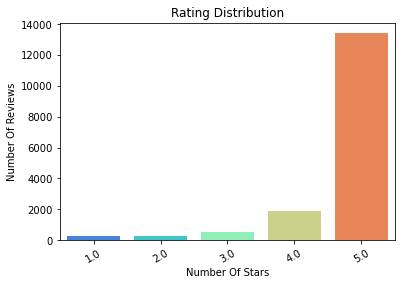

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(df1.rating.value_counts().sort_values(ascending=True).index,
                 y=df1.rating.value_counts().sort_values(ascending=True),palette="rainbow")
plt.title("Rating Distribution")
plt.xlabel("Number Of Stars")
plt.ylabel("Number Of Reviews")
plt.xticks(rotation=30)
plt.savefig("sent.jpeg",dpi=300,bbox_inches="tight")

In [29]:
df1 = df1[df1.rating!=3]

In [30]:
import numpy as np
df1['sentiment'] = np.where(df1['rating'] >= 4, 'positive', 'negative') # 4 ve üstüne pozitif değilse negatif ver.

In [31]:
df1.sentiment.value_counts(normalize=True) # biraz feature eng. biraz EDA yaptık.

2020-10-06 14:29:11,495 : INFO : NumExpr defaulting to 8 threads.


positive    0.964882
negative    0.035118
Name: sentiment, dtype: float64

In [32]:
df1.columns

Index(['name', 'rating', 'comments', 'summary', 'info', 'street', 'postCode',
       'sentiment'],
      dtype='object')

In [34]:
from wordcloud import STOPWORDS
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
s_words= list(stopwords.words('english'))
stop_words = list(STOPWORDS)+ ["what", "us", "this","well","there","much","us","and","you're","in","where","when","just","how","is","ha","re","are"
                              "hi","aren't", 'couldn','could','couldnt',"couldn't",'did','had','have','must','does','should','was',"it's"
                               "didn't", "doesn't", "don't", "hadn't", "hasn't", "haven't", "isn't", 'let', 'll',"may",'were','is','has','must',
                               'mustn', 'rt', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn','realli','now','got','man','people','a',
                               'becaus','caus',"one","im","guy","someone","two","nearby","i","he's","she's","we","it","they","wouldn’t","i've",
                               'aren', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'sdidn', 've',"will","restaurant"]



def remove_stopwords(txt):
    
    sentence = []
    s = ""
    for word in txt.split():    
        if(word not in stop_words):      
            sentence.append(word)
            s = ' '.join(sentence)
    return s

df1.comments = df1.comments.map(remove_stopwords) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\istay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()
nltk.download("wordnet")
def lem_words(text):
    
    return " ".join([lemm.lemmatize(word) for word in text.split()])
    


df1.comments = df1.comments.apply(lambda metin: lem_words(metin))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\istay\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [38]:
df1.summary = df1.summary.fillna("")
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15861 entries, 0 to 159024
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       15861 non-null  object 
 1   rating     15861 non-null  float64
 2   comments   15861 non-null  object 
 3   summary    15861 non-null  object 
 4   info       15861 non-null  object 
 5   street     15861 non-null  object 
 6   postCode   15861 non-null  object 
 7   sentiment  15861 non-null  object 
dtypes: float64(1), object(7)
memory usage: 1.1+ MB


In [39]:
# PreProcessing

# remove numbers, captial letters and punctuation
import re
import string

alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())


df1.summary = df1.summary.map(alphanumeric).map(punc_lower)
df1.comments = df1.comments.map(alphanumeric).map(punc_lower)

In [41]:
def remove_url(txt):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',txt)

def remove_html(txt):
    html=re.compile(r'<.*?>')
    return html.sub(r'',txt)

# U+1F970
def remove_emoji(txt):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', txt)
def remove(emoji):
    em = re.compile(r"🥰")
    return em.sub(r"",emoji)
def remove_blank_space(text):
    return re.sub("\s\s+" , " ", text)
def remove_blank2(text):
    text = text.strip()
    return text
def remove_all(ReviewText):
    ReviewText = ReviewText.replace("(<br/>)", "")
    ReviewText = ReviewText.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.replace('(&amp)', '')
    ReviewText = ReviewText.replace('(&gt)', '')
    ReviewText = ReviewText.replace('(&lt)', '')
    ReviewText = ReviewText.replace('(\xa0)', ' ') 
    ReviewText = ReviewText.replace(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', ' ') 
    return ReviewText

    
df1.comments = df1.comments.apply(remove_url)
df1.comments = df1.comments.apply(remove_html)
df1.comments = df1.comments.apply(remove_emoji)
df1.comments = df1.comments.apply(remove)
df1.comments = df1.comments.apply(remove_blank_space)
df1.comments = df1.comments.apply(remove_blank2)
df1.comments = df1.comments.apply(remove_all)
df1.comments = df1.comments.map(remove_stopwords)
df1.comments[0]

'good food value money attentive staff make visit memorable restuarant worth special occasion'

--------Top 300 R - All Reviews-------------


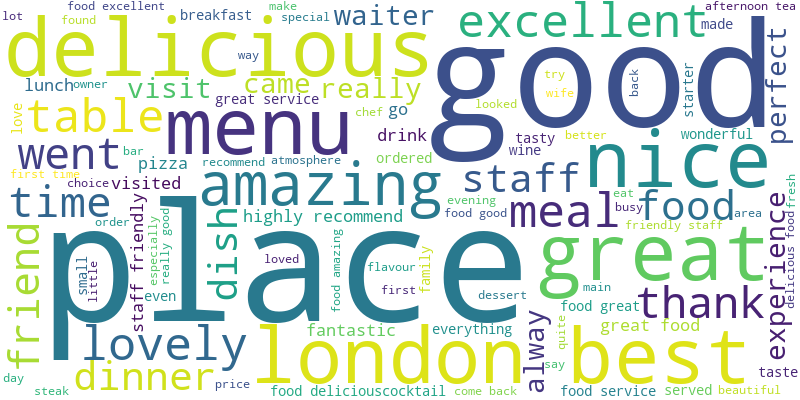

In [39]:
from wordcloud import WordCloud

txt = ','.join(list(df1.comments.values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white",stopwords = stop_words, 
                      min_font_size = 5, width=800, height=400, 
                      max_words=100, contour_width=3, contour_color='steelblue').generate(txt)

# Visualize the word cloud
print("--------Top 300 R - All Reviews-------------")
wordcloud.to_image()

In [40]:
wordcloud.to_file("a_reviews.png")

--------Negative Reviews-------------


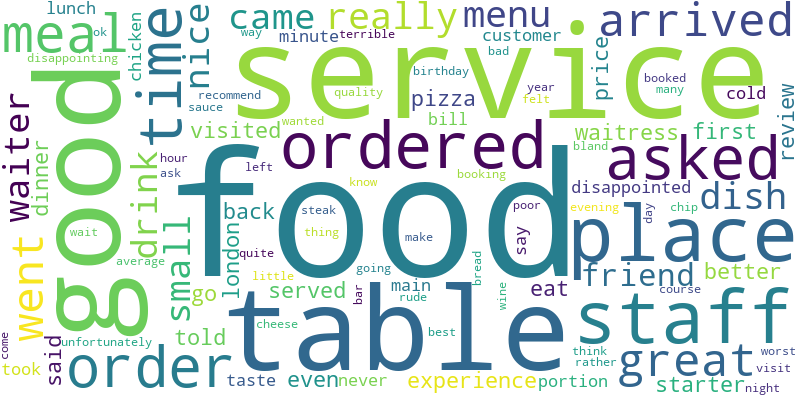

In [41]:
txt = ','.join(list(df1[df1.sentiment=="negative"].comments.values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white",stopwords = stop_words, 
                      min_font_size = 5, width=800, height=400, 
                      max_words=100, contour_width=3, contour_color='steelblue').generate(txt)
wordcloud.to_file("n_reviews.png")
# Visualize the word cloud
print("--------Negative Reviews-------------")
wordcloud.to_image()

--------Positive Reviews-------------


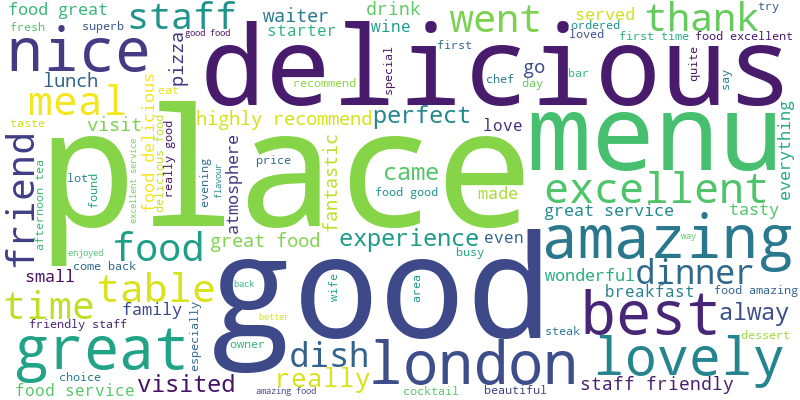

In [42]:
txt = ','.join(list(df1[df1.sentiment=="positive"].comments.values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white",stopwords = stop_words, 
                      min_font_size = 5, width=800, height=400, 
                      max_words=100, contour_width=3, contour_color='steelblue').generate(txt)

# Visualize the word cloud
print("--------Positive Reviews-------------")
wordcloud.to_image()

In [43]:
wordcloud.to_file("positive_reviews.png")

In [43]:
stopw = stop_words + ["food","dinner","menu","service","staff","starter","place","meal","lunch","drink","restaurant","burger","pub",
              "waiter","family","wine","main","bar","eat","area","evening","pizza","came","went","made","dessert","breakfast",
              "cocktail","table","booked","london","way","many","think","another","took","pasta","fish","dish","pay","going",
              "dessert","wife","came","go","say"]

In [45]:
from collections import Counter
c = Counter()
for txt in df1.comments.values:
    for word in txt.split():
        c[word] += 1
#en sık kullanılan on kelime
c.most_common(10)

[('food', 9843),
 ('service', 5788),
 ('great', 5378),
 ('good', 4298),
 ('staff', 4240),
 ('place', 3316),
 ('friendly', 3253),
 ('delicious', 2701),
 ('amazing', 2649),
 ('lovely', 2541)]

In [46]:
# en az kullanılan 30 kelime
set([w for (w, wc) in c.most_common()[:-29:-1]])

{'abundantly',
 'adaptations',
 'bedford',
 'bubbels',
 'cheddar',
 'compliant',
 'concentrating',
 'conduct',
 'connecting',
 'dayana',
 'dishonest',
 'drops',
 'engineer',
 'enjoyd',
 'excepltional',
 'grins',
 'grudgingly',
 'implore',
 'josé',
 'olds',
 'perfetic',
 'returningmore',
 'shotkora',
 'slither',
 'soutzoukakia',
 'thrives',
 'umami',
 'vasilis'}

--------Restaurant Information-------------


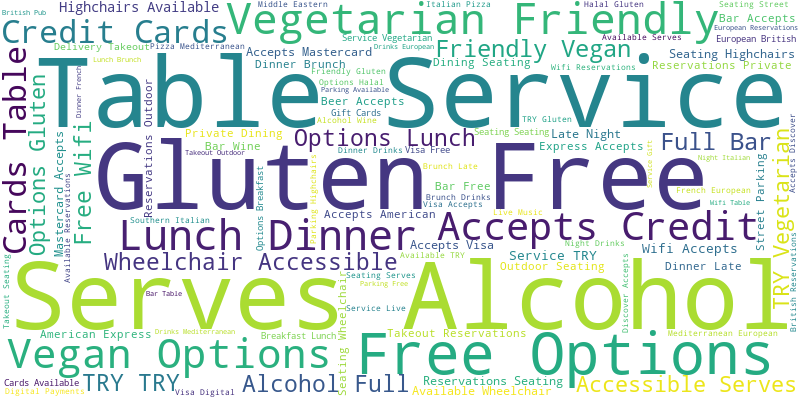

In [47]:

#stopwords2= stopwords+["TRY\\xa0"]

txt = ','.join(list(df1["info"].fillna(" ").values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white",stopwords = stop_words, 
                      min_font_size = 5, width=800, height=400, 
                      max_words=100, contour_width=3, contour_color='steelblue').generate(txt)
#wordcloud.to_file("restaurant_info.png")
# Visualize the word cloud
print("--------Restaurant Information-------------")
wordcloud.to_image()

In [44]:
## Kökleri ayırdıktan sonra bakem noluyo
# köklerine ayıralım.
# According to https://www.nltk.org/howto/stem.html Snowball is better than PorterStremmer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
def stem_words(text):

    return " ".join([stemmer.stem(word) for word in text.split()])
df1.comments = df1.comments.apply(lambda txt: stem_words(txt))


df1.comments[0]

'good food valu money attent staff make visit memor restuar worth special occas'

In [49]:
from textblob import TextBlob
df1['polarity'] = df1['comments'].map(lambda text: TextBlob(text).sentiment.polarity)

In [50]:
mc = c.most_common(20)

In [51]:
df2 = pd.DataFrame(mc,columns=["word","freq"])
df2

word  freq
0         food  9843
1      service  5788
2        great  5378
3         good  4298
4        staff  4240
5        place  3316
6     friendly  3253
7    delicious  2701
8      amazing  2649
9       lovely  2541
10        time  2537
11      really  2511
12   excellent  2465
13        menu  2145
14      london  2035
15        best  1989
16        back  1979
17   recommend  1942
18        nice  1926
19  atmosphere  1652

In [52]:
import plotly.express as px

fig = px.bar(df2, x='word', y='freq',
             hover_data=['word', 'freq'], color='freq',
             title='Most Common 20 Words',
             height=400)
fig.show()

In [53]:
df1["word count"] = df1.comments.str.len()

fig = px.histogram(df1, x="word count", nbins=200, title='Word Count')
fig.show()

In [54]:

fig = px.histogram(df1, x="polarity", nbins=20, title='Text Polarity')
fig.show()

In [46]:
df1.sentiment = df1.sentiment.map({"negative":0,"positive":1})
name_list = list(df1.groupby("name")["sentiment"].mean().sort_values(ascending=False).head(10).index)

In [56]:
df1.groupby("name")["polarity"].mean().sort_values(ascending=True).head(10)

name
Patty & Bun                 0.164952
William's Bar and Bistro    0.206171
 Flat Three Restaurant      0.226607
 Dhaba@49                   0.229623
It's all Greek to me        0.233103
Boxpark Shoreditch          0.239298
 Anglo                      0.240249
 Stuzzico                   0.243775
 Fine Foods                 0.244477
 Mere                       0.245233
Name: polarity, dtype: float64

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

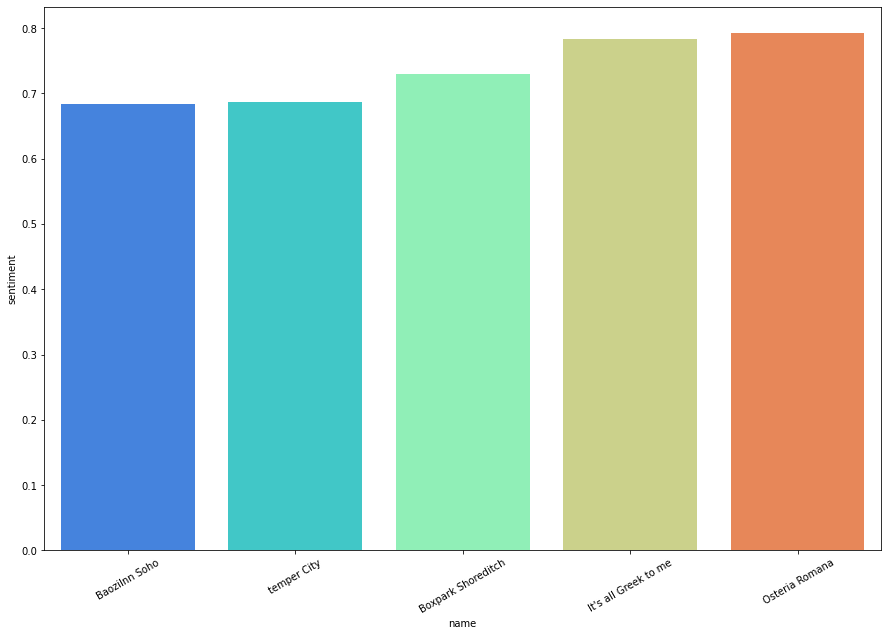

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
sns.barplot(df1.groupby("name")["sentiment"].mean().sort_values(ascending=True).head(5).index,
                 y=df1.groupby("name")["sentiment"].mean().sort_values(ascending=True).head(5),palette="rainbow")
plt.xticks(rotation=30)
#plt.savefig("sent.jpeg",dpi=300,bbox_inches="tight")

In [58]:
import plotly.express as px
fig = px.box(df1[df1.name.isin(name_list)], x="name",y='polarity', color="name",
             title="Polarity based On Restaurant Name",
             hover_data=["polarity"])
fig.show()

### Prepare data for modeling

In [47]:
df1 = df1.drop(columns=["users"])
df1 = df1.drop_duplicates()

In [48]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15860 entries, 0 to 159024
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       15860 non-null  object 
 1   rating     15860 non-null  float64
 2   comments   15860 non-null  object 
 3   summary    15860 non-null  object 
 4   info       15860 non-null  object 
 5   street     15860 non-null  object 
 6   postCode   15860 non-null  object 
 7   sentiment  15860 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 1.1+ MB


In [61]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

In [62]:
def model_produce(X,y,model,min_df,ngram_range):
    m = model(stop_words=stopw, min_df=min_df,max_df=.85, token_pattern="\\b[a-z][a-z]+\\b",ngram_range=ngram_range)
    m2 = m.fit_transform(X)
    # modeldf = pd.DataFrame(m2.toarray(), columns=m.get_feature_names())
   # m3  = pd.concat([df1["polarity"],modeldf],axis=1)
    X_under, y_under = RandomUnderSampler(random_state=42).fit_sample(m2,y)
    X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.3, random_state=42,stratify = y_under)
  
    return X_train, X_test, y_train, y_test

In [63]:
from collections import Counter

X = df1.comments
y = df1.sentiment

model = TfidfVectorizer
ngram_range =(1,2)
X_train, X_test, y_train, y_test = model_produce(X,y,model,1,ngram_range)


Counter(y_train)

Counter({1: 390, 0: 389})

In [64]:
! pip install eli5
import eli5

C:\Users\istay\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

C:\Users\istay\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.



In [65]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predict Negative', 'predict Positive'], 
                yticklabels=['actual Negative', 'actual Positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    print(cm_results)
    return cm_results

In [66]:
perform_list = []
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import time
kf = StratifiedKFold(n_splits=20, random_state=42,shuffle=True)
def calculate_metrics(model, X_train, X_test, y_train, y_test):
    begin = time.time()
    model.fit(X_train, y_train)
    now =time.time()
    y_pred = model.predict(X_test)
    test_accuracy = model.score(X_test, y_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(model)
    print('CV accuracy:', test_accuracy)
    print('Precision:{:6.4f},   Recall:{:6.4f}, F1:{:6.4f}'.format(precision, 
                                                                   recall, f1))
    cv_acc = cross_val_score(model, X_train, y_train, cv=kf,scoring="accuracy").mean()
    cv_f1 = cross_val_score(model, X_train, y_train, cv=kf,scoring="f1").mean()
    perform_list.append(dict([
            ("Model" , model.__class__.__name__),
            ("Time x 1000",(now-begin)*1000),
            ("Train Accuracy", model.score(X_train,y_train)),
            ("Test Accuracy", test_accuracy),
            ("Precision" , precision ),
            ("recall",recall),
            ("f1",f1),
            ("CV Accuracy",cv_acc),
            ("CV f1",cv_f1)]))  

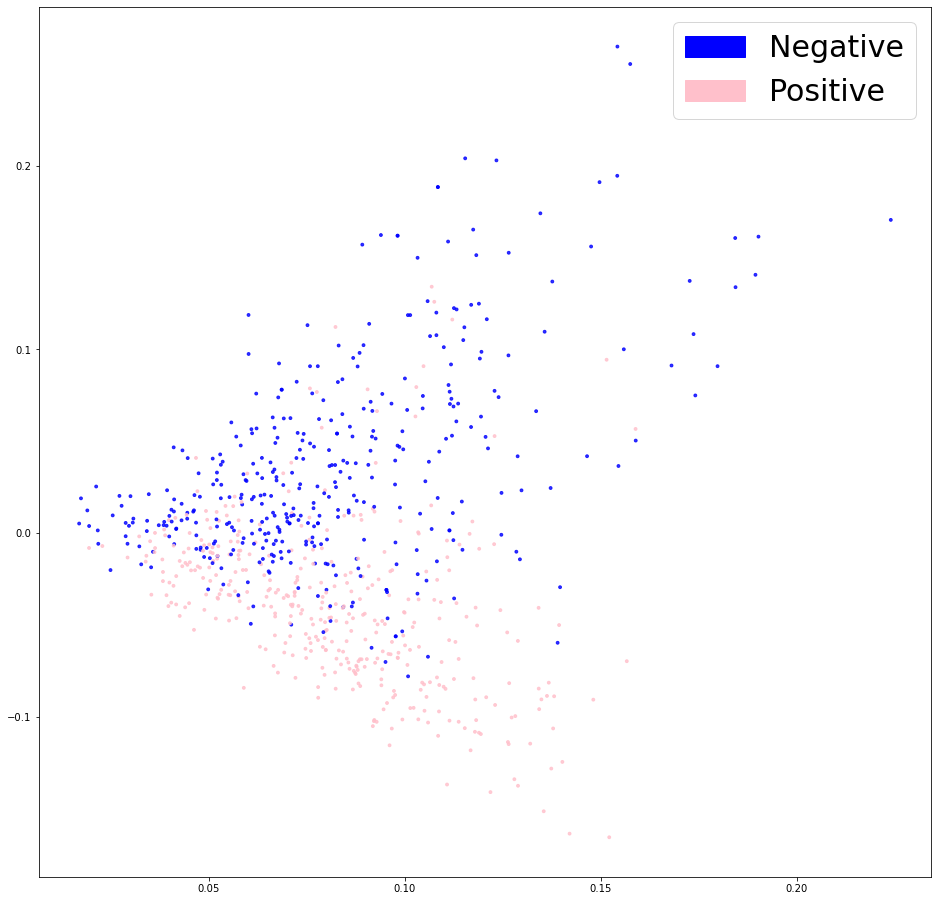

In [67]:
# Kaynak : https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['blue','pink','pink']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='blue', label='Negative')
            green_patch = mpatches.Patch(color='pink', label='Positive')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train, y_train)
plt.show()

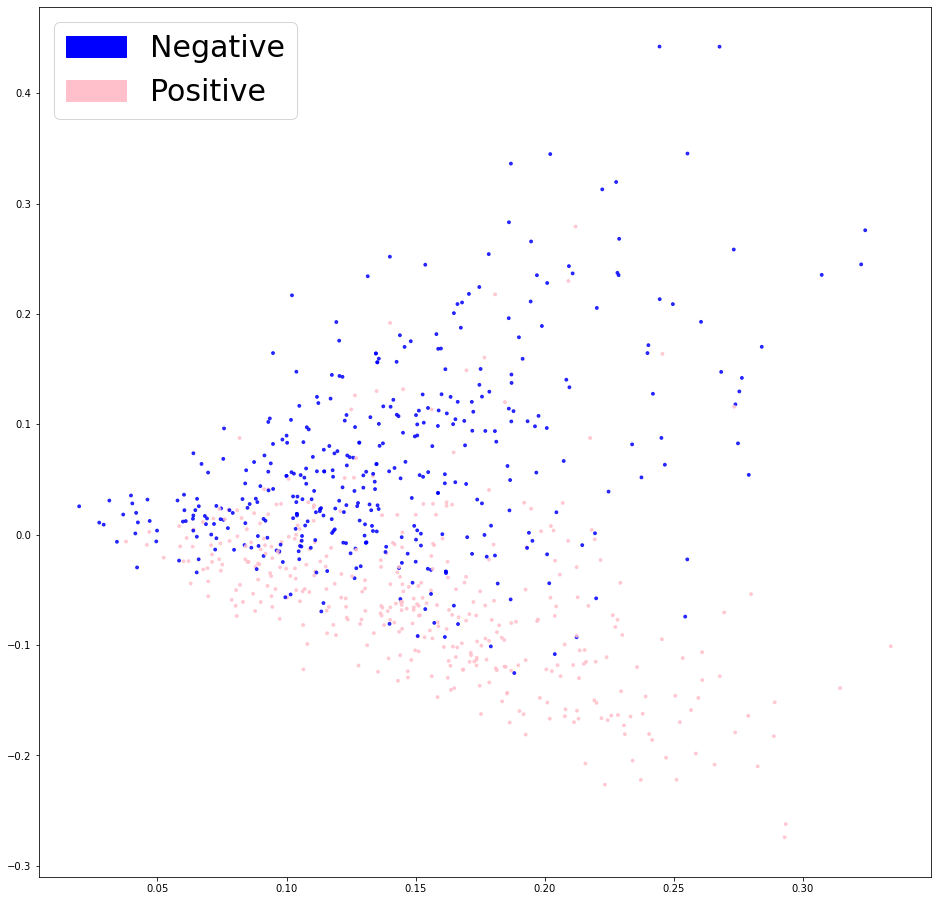

In [68]:
model = TfidfVectorizer
ngram_range = (1,1)

X_train2, X_test2, y_train2, y_test2  = model_produce(X,y,model,4,ngram_range)

fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train2, y_train2)
plt.show() 

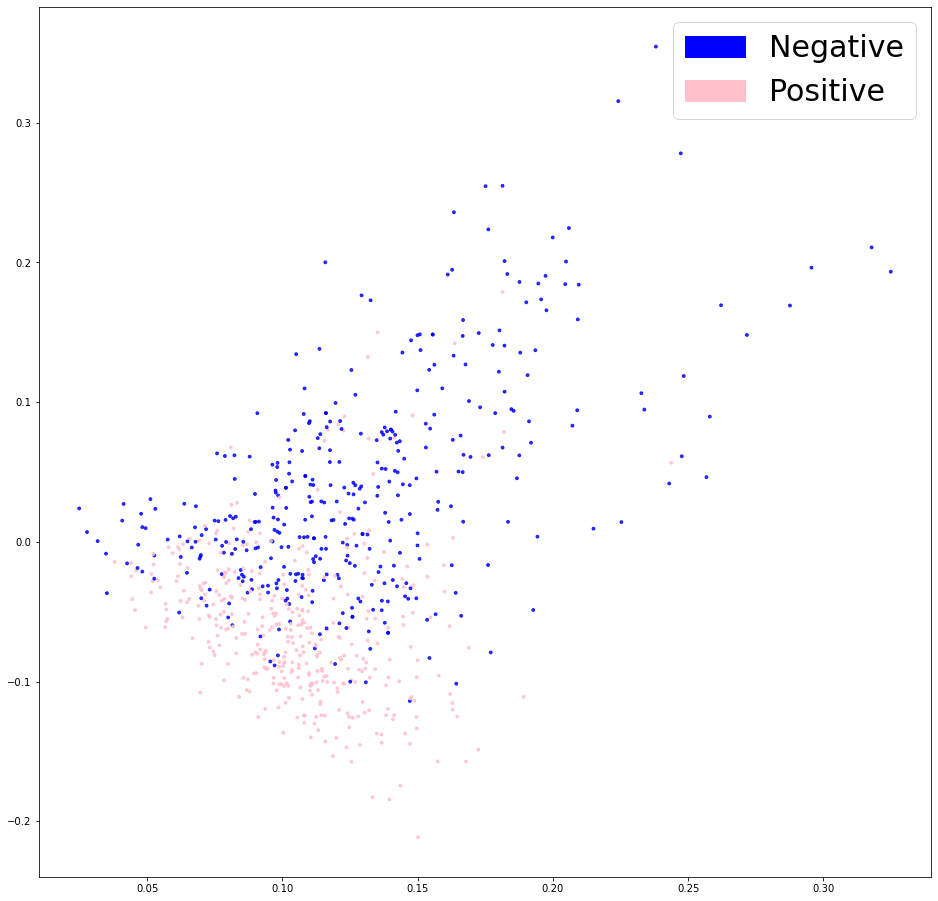

In [69]:
model = TfidfVectorizer
ngram_range =(1,2)


X_train3, X_test3, y_train3, y_test3  = model_produce(X,y,model,4,ngram_range)


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train3, y_train3)
plt.show() # biraz daha ayrıştı.

In [70]:
from sklearn.metrics import  precision_score, recall_score, precision_recall_curve,f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
perform_list = []
XGB = XGBClassifier()
GBC = GradientBoostingClassifier()
LR = LogisticRegression(solver='liblinear')
LR2 = LogisticRegression()
MNB = MultinomialNB()
RF = RandomForestClassifier()
BNB = BernoulliNB()
GNB = GaussianNB()
LSVC = LinearSVC()

models = [LR,GBC,MNB,BNB,RF,XGB,LSVC]


for model in models:
    calculate_metrics(model,X_train2, X_test2, y_train2, y_test2)
    print('------------------Model Result :---------------------')

LogisticRegression(solver='liblinear')
CV accuracy: 0.8955223880597015
Precision:0.9074,   Recall:0.8802, F1:0.8936
------------------Model Result :---------------------
GradientBoostingClassifier()
CV accuracy: 0.8537313432835821
Precision:0.8986,   Recall:0.7964, F1:0.8444
------------------Model Result :---------------------
MultinomialNB()
CV accuracy: 0.9014925373134328
Precision:0.9036,   Recall:0.8982, F1:0.9009
------------------Model Result :---------------------
BernoulliNB()
CV accuracy: 0.8716417910447761
Precision:0.8407,   Recall:0.9162, F1:0.8768
------------------Model Result :---------------------
RandomForestClassifier()
CV accuracy: 0.8776119402985074
Precision:0.9091,   Recall:0.8383, F1:0.8723
------------------Model Result :---------------------
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
             

In [71]:
per = pd.DataFrame(perform_list)
per = per[["Model","Time x 1000","Train Accuracy","Test Accuracy","Precision","recall","f1","CV Accuracy","CV f1"]]
per

Model  Time x 1000  Train Accuracy  Test Accuracy  \
0          LogisticRegression     6.000280        0.970475       0.895522   
1  GradientBoostingClassifier   562.038660        0.956354       0.853731   
2               MultinomialNB     2.001524        0.975610       0.901493   
3                 BernoulliNB     1.002073        0.953787       0.871642   
4      RandomForestClassifier   479.032516        1.000000       0.877612   
5               XGBClassifier   268.134117        0.998716       0.862687   
6                   LinearSVC     3.999472        1.000000       0.865672   

   Precision    recall        f1  CV Accuracy     CV f1  
0   0.907407  0.880240  0.893617     0.867848  0.865848  
1   0.898649  0.796407  0.844444     0.804993  0.800219  
2   0.903614  0.898204  0.900901     0.867848  0.868237  
3   0.840659  0.916168  0.876791     0.840891  0.855548  
4   0.909091  0.838323  0.872274     0.852395  0.839332  
5   0.885350  0.832335  0.858025     0.828003  0.820826  
6   0.867470  0.862275  0.864865     0.857591  0.857599

[0.896, 0.907, 0.88, 0.893]


[0.896, 0.907, 0.88, 0.893]

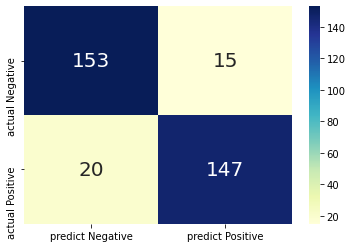

In [72]:
mb2 = LogisticRegression() # LogReg, Multi, Bernoulli
mb2.fit(X_train2, y_train2)

y_pred1 = mb2.predict(X_test2)

conf_matrix(y_test2,y_pred1)

[0.901, 0.904, 0.898, 0.901]


[0.901, 0.904, 0.898, 0.901]

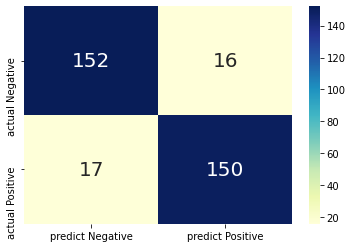

In [73]:
mb = MultinomialNB() # LogReg, Multi, Bernoulli
mb.fit(X_train2, y_train2)

y_pred1 = mb.predict(X_test2)

conf_matrix(y_test2,y_pred1)

In [74]:
#target_names = ["Negative","Positive"]
#eli5.show_weights(LR, vec=tf, top=10,
#                  target_names=target_names)

In [75]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=50, random_state=42,shuffle=True)

import numpy as np

mnb = MultinomialNB()

parameters = {'alpha':np.linspace(0,9)}


clf2 = GridSearchCV(mnb, parameters, n_jobs=5, 
                   cv=kf,
                   scoring='accuracy',
                   refit=True)

clf2.fit(X_train2, y_train2)
clf2.best_params_

{'alpha': 2.2040816326530615}

[0.901, 0.904, 0.898, 0.901]


[0.901, 0.904, 0.898, 0.901]

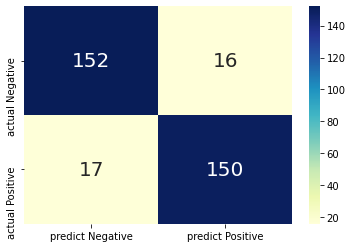

In [76]:
# Best 2 Model

mnb = MultinomialNB(alpha = 2.2040816326530615)
mb.fit(X_train2, y_train2)

y_pred1 = mb.predict(X_test2)

conf_matrix(y_test2,y_pred1)

In [77]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

lr = LogisticRegression()

clf2 = GridSearchCV(lr, grid, n_jobs=5, 
                   cv=kf,
                   scoring='accuracy',
                   refit=True)

clf2.fit(X_train2, y_train2)
clf2.best_params_

{'C': 0.1, 'penalty': 'l2'}

[0.887, 0.906, 0.862, 0.883]


[0.887, 0.906, 0.862, 0.883]

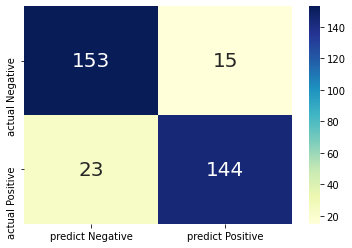

In [78]:
lr = LogisticRegression(C = 0.1, penalty = 'l2')
lr.fit(X_train2, y_train2)

y_pred1 = lr.predict(X_test2)

conf_matrix(y_test2,y_pred1)

In [79]:
plot_roc_curves()

NameError: name 'plot_roc_curves' is not defined

In [80]:
m = TfidfVectorizer(stop_words=stopw, min_df=4,max_df=.85, token_pattern="\\b[a-z][a-z]+\\b")
m2 = m.fit_transform(X)
modeldf = pd.DataFrame(m2.toarray(), columns=m.get_feature_names())
m3  = pd.concat([df1["polarity"],modeldf],axis=1)
X_under, y_under = RandomUnderSampler(random_state=42).fit_sample(m2,y)
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.3, random_state=42,stratify = y_under)

eli5.show_weights(lr, vec=m)

In [81]:
XGB = XGBClassifier()
GBC = GradientBoostingClassifier()
LR = LogisticRegression(solver='liblinear')
LR2 = LogisticRegression()
MNB = MultinomialNB()
RF = RandomForestClassifier()
BNB = BernoulliNB()
GNB = GaussianNB()
LSVC = LinearSVC()

models = [LR,GBC,MNB,BNB,RF,XGB,LSVC]


m = CountVectorizer(stop_words=stopw, min_df=4,max_df=.85, token_pattern="\\b[a-z][a-z]+\\b")
m2 = m.fit_transform(X)
X_under, y_under = RandomUnderSampler(random_state=42).fit_sample(m2,y)
X_trainc, X_testc, y_trainc, y_testc = train_test_split(X_under, y_under, test_size=0.3, random_state=42,stratify = y_under)




for model in models:
    calculate_metrics(model,X_trainc, X_testc, y_trainc, y_testc )
    print('------------------Model Result :---------------------')

LogisticRegression(solver='liblinear')
CV accuracy: 0.8656716417910447
Precision:0.8765,   Recall:0.8503, F1:0.8632
------------------Model Result :---------------------
GradientBoostingClassifier()
CV accuracy: 0.844776119402985
Precision:0.8710,   Recall:0.8084, F1:0.8385
------------------Model Result :---------------------
MultinomialNB()
CV accuracy: 0.9044776119402985
Precision:0.9091,   Recall:0.8982, F1:0.9036
------------------Model Result :---------------------
BernoulliNB()
CV accuracy: 0.8716417910447761
Precision:0.8407,   Recall:0.9162, F1:0.8768
------------------Model Result :---------------------
RandomForestClassifier()
CV accuracy: 0.8835820895522388
Precision:0.9103,   Recall:0.8503, F1:0.8793
------------------Model Result :---------------------
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              

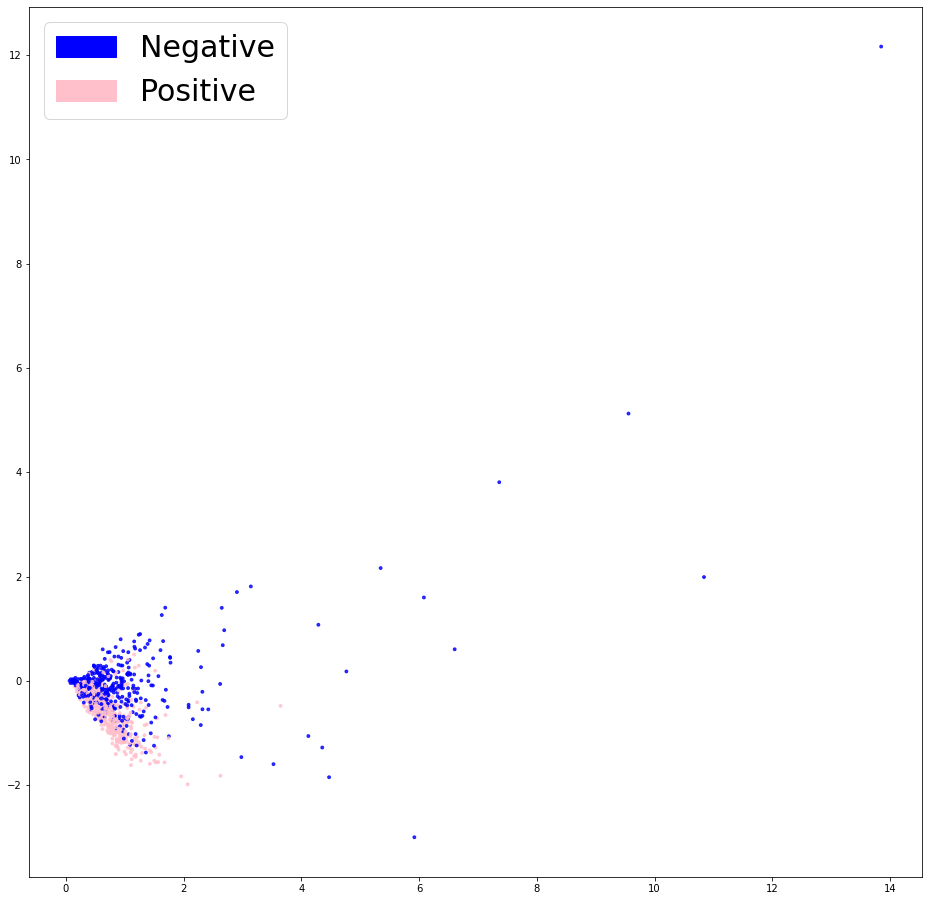

In [82]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_trainc, y_trainc)
plt.show()

In [83]:
per2 = pd.DataFrame(perform_list)
per2 = per2[["Model","Time x 1000","Train Accuracy","Test Accuracy","Precision","recall","f1","CV Accuracy","CV f1"]]
per2

Model  Time x 1000  Train Accuracy  Test Accuracy  \
0           LogisticRegression     6.000280        0.970475       0.895522   
1   GradientBoostingClassifier   562.038660        0.956354       0.853731   
2                MultinomialNB     2.001524        0.975610       0.901493   
3                  BernoulliNB     1.002073        0.953787       0.871642   
4       RandomForestClassifier   479.032516        1.000000       0.877612   
5                XGBClassifier   268.134117        0.998716       0.862687   
6                    LinearSVC     3.999472        1.000000       0.865672   
7           LogisticRegression    22.879839        1.000000       0.865672   
8   GradientBoostingClassifier   849.229097        0.931964       0.844776   
9                MultinomialNB    43.573380        0.971759       0.904478   
10                 BernoulliNB     2.000093        0.953787       0.871642   
11      RandomForestClassifier   680.855513        1.000000       0.883582   
12               XGBClassifier   328.218460        0.988447       0.850746   
13                   LinearSVC     6.999731        1.000000       0.835821   

    Precision    recall        f1  CV Accuracy     CV f1  
0    0.907407  0.880240  0.893617     0.867848  0.865848  
1    0.898649  0.796407  0.844444     0.804993  0.800219  
2    0.903614  0.898204  0.900901     0.867848  0.868237  
3    0.840659  0.916168  0.876791     0.840891  0.855548  
4    0.909091  0.838323  0.872274     0.852395  0.839332  
5    0.885350  0.832335  0.858025     0.828003  0.820826  
6    0.867470  0.862275  0.864865     0.857591  0.857599  
7    0.876543  0.850299  0.863222     0.842417  0.838533  
8    0.870968  0.808383  0.838509     0.821750  0.809149  
9    0.909091  0.898204  0.903614     0.858833  0.855646  
10   0.840659  0.916168  0.876791     0.848583  0.862714  
11   0.910256  0.850299  0.879257     0.858083  0.843068  
12   0.854545  0.844311  0.849398     0.828000  0.821709  
13   0.833333  0.838323  0.835821     0.844583  0.845737

[0.904, 0.909, 0.898, 0.903]


[0.904, 0.909, 0.898, 0.903]

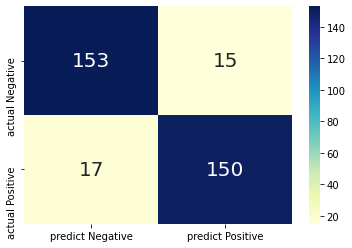

In [84]:
mb = MultinomialNB() # LogReg, Multi, Bernoulli
mb.fit(X_trainc, y_trainc)

y_pred1 = mb.predict(X_testc)

conf_matrix(y_testc,y_pred1)

In [85]:
mnb = MultinomialNB()

parameters = {'alpha':np.linspace(0.0001,9)}


clf2 = GridSearchCV(mnb, parameters, n_jobs=5, 
                   cv=kf,
                   scoring='accuracy',
                   refit=True)

clf2.fit(X_train2, y_train2)
clf2.best_params_

{'alpha': 2.204157142857143}

[0.907, 0.874, 0.952, 0.911]


[0.907, 0.874, 0.952, 0.911]

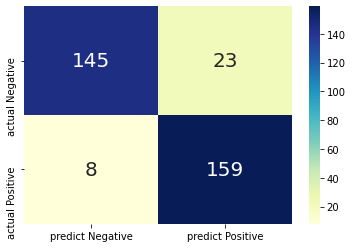

In [110]:
mnb = MultinomialNB(alpha = 2.204157142857143)
mnb.fit(X_trainc, y_trainc)

y_pred1 = mb.predict(X_testc)

conf_matrix(y_testc,y_pred1)

In [87]:
parameters = [{'alpha':np.linspace(0.1,1,10)}]


clf = GridSearchCV(BernoulliNB(), parameters, n_jobs=5, 
                   cv=kf,
                   scoring='accuracy',
                   refit=True)
clf.fit(X_trainc, y_trainc) # running the grid search
clf.best_params_

{'alpha': 0.4}

[0.878, 0.862, 0.898, 0.88]


[0.878, 0.862, 0.898, 0.88]

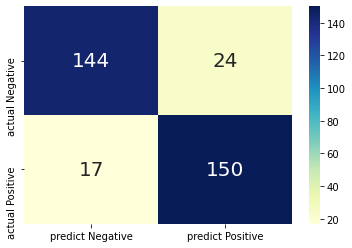

In [88]:
bnb = BernoulliNB(alpha = 0.30000000000000004)
bnb.fit(X_trainc, y_trainc)

y_pred1 = bnb.predict(X_testc)

conf_matrix(y_testc,y_pred1)

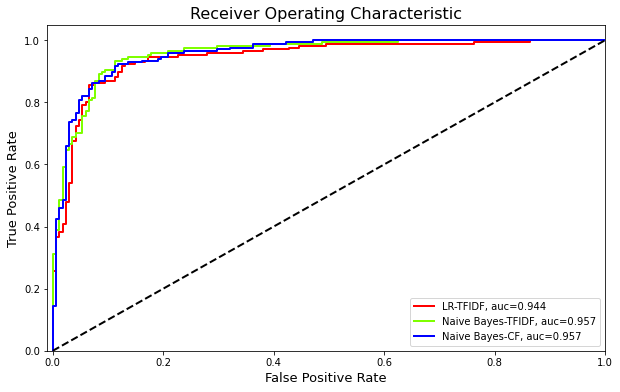

In [89]:
mb = MultinomialNB().fit(X_train2, y_train2)


y_pred1 = mb.predict(X_test2)

lr_proba = lr.predict_proba(X_test2)
nb_proba = mb.predict_proba(X_test2)
nb_proba2 = mnb.predict_proba(X_testc)
#l_propba = LSVC.predict_proba(X_test2)

def plot_roc_curves():
    plt.figure(figsize=(10,6))
    lw = 2    
    
    # Logistic Regression
    fpr, tpr, thresholds = roc_curve(y_test2, lr_proba[:,1], pos_label=1)
    auc_lr = roc_auc_score(y_test2, lr_proba[:,1])
    plt.plot(fpr, tpr, color='r',
             lw=lw, label='LR-TFIDF, auc=%.3f' % auc_lr)
         
    
    # Naive Bayes
    fpr, tpr, thresholds = roc_curve(y_test2, nb_proba[:,1], pos_label=1)
    auc_nbc = roc_auc_score(y_test2, nb_proba[:,1])
    plt.plot(fpr, tpr, color='chartreuse',
             lw=lw, label='Naive Bayes-TFIDF, auc=%.3f' % auc_nbc)

    # Naive Bayes 2
    fpr, tpr, thresholds = roc_curve(y_test2, nb_proba2[:,1], pos_label=1)
    auc_nb = roc_auc_score(y_testc, nb_proba2[:,1])
    plt.plot(fpr, tpr, color='b',
             lw=lw, label='Naive Bayes-CF, auc=%.3f' % auc_nbc)

    
    plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.title('Receiver Operating Characteristic', fontsize=16)
    plt.legend(loc="lower right")
    plt.show()
    #plt.savefig("roc.jpeg",dpi=300,bbox_inches="tight")
plot_roc_curves()

### Recommendation Engine

Based on Restaurant information and description(summary)

In [49]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

In [31]:
df.summary = df.summary.fillna("")

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159150 entries, 0 to 159149
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   name      159150 non-null  object 
 1   rating    159150 non-null  float64
 2   comments  159150 non-null  object 
 3   summary   159150 non-null  object 
 4   info      159150 non-null  object 
 5   street    159150 non-null  object 
 6   postCode  159150 non-null  object 
dtypes: float64(1), object(6)
memory usage: 8.5+ MB


In [51]:
rec = pd.DataFrame(df[["info","summary"]].astype("str").apply(lambda x: " ".join(x),axis=1),columns=["full"])
rec["name"] = df["name"]

In [52]:
rec = rec.drop_duplicates()
rec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3022 entries, 0 to 159131
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   full    3022 non-null   object
 1   name    3022 non-null   object
dtypes: object(2)
memory usage: 70.8+ KB


In [53]:
all_comments = df.groupby("name",as_index=False).agg({"comments" : lambda x: " ".join(x)})
all_comments = all_comments.drop_duplicates()
all_comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2815 entries, 0 to 2814
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      2815 non-null   object
 1   comments  2815 non-null   object
dtypes: object(2)
memory usage: 66.0+ KB


In [54]:
rec = pd.merge(rec, all_comments, how='inner')
rec.full = rec.full.fillna("")
rec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3022 entries, 0 to 3021
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   full      3022 non-null   object
 1   name      3022 non-null   object
 2   comments  3022 non-null   object
dtypes: object(3)
memory usage: 94.4+ KB


In [55]:
rec = rec.drop_duplicates()
rec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3022 entries, 0 to 3021
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   full      3022 non-null   object
 1   name      3022 non-null   object
 2   comments  3022 non-null   object
dtypes: object(3)
memory usage: 94.4+ KB


In [56]:
rc = pd.DataFrame(rec[["comments","full"]].astype("str").apply(lambda x: " ".join(x),axis=1),columns=["full"])
rc["name"] =rec["name"]

In [58]:
rc = rc.drop_duplicates()
rc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3022 entries, 0 to 3021
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   full    3022 non-null   object
 1   name    3022 non-null   object
dtypes: object(2)
memory usage: 70.8+ KB


In [64]:
rc = rc.drop_duplicates(subset=["name"])
rc["name"] =rec["name"]

In [65]:
rc.full.nunique()

2795

In [66]:
#rc.full = rc.full.map(remove_stopwords) 
#rc.full = rc.full.apply(remove_blank_space)
#rc.full = rc.full.apply(lambda metin: lem_words(metin))
#rc.full = rc.full.apply(lambda metin: lem_words(metin))
#rc.full = rc.full.map(alphanumeric).map(punc_lower)

In [ ]:
tfidf_vec = TfidfVectorizer(stop_words="english",min_df=1,max_df=.85,ngram_range=(1, 3), token_pattern="\\b[a-z][a-z][a-z]+\\b")

# TfIdf matrix
matrix = tfidf_vec.fit_transform(rc.full)
# Compute the cosine similarity
cosine_sim = linear_kernel(matrix, matrix)

In [ ]:
import pickle
with open('cosine_sim.pickle', 'wb') as handle:
    pickle.dump(cosine_sim, handle)

In [ ]:
#rec.name = rec.name.reset_index()
indices = pd.Series(rc.name)

In [45]:
indices

0                    Amrutha Lounge
1                             Dobar
2                   The Lounge Cafe
3              Andy's Greek Taverna
4             Room 43 Bar & Kitchen
                   ...             
3017                    Archipelago
3018        Ottolenghi Spitalfields
3019          Revolution Leadenhall
3020              The Mayflower Pub
3021    Pane Cunzato - Pizza & more
Name: name, Length: 3022, dtype: object

In [117]:
indices.to_csv("indices.csv")

In [46]:
import pandas as pd
indices = pd.read_csv("indices.csv")

In [5]:
indices = indices["name"]
indices

0                                          Amrutha Lounge
1                                                   Dobar
2                                         The Lounge Cafe
3                                    Andy's Greek Taverna
4                                   Room 43 Bar & Kitchen
                              ...                        
3018                              Ottolenghi Spitalfields
3019                                Revolution Leadenhall
3020                                    The Mayflower Pub
3021                          Pane Cunzato - Pizza & more
3022                                 name\n0          ...
Name: name, Length: 3023, dtype: object

In [106]:
rc = rc.reset_index()

In [107]:
def get_n_recommendations(title, cosine_sim ,top_n):
    
    '''
    I choose the restaurant which is not null restaurant information
    '''    
    recommended_restaurant = []    
    # restaurant match indices
    idx = indices[indices == title].index[0]
    # similarity scores
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    # top n
    top_n_indexes = list(score_series.iloc[1:top_n+1].index)
    for i in top_n_indexes:
        recommended_restaurant.append(list(indices)[i])
        
    return recommended_restaurant

In [119]:
"indices.csv"

0                                             Amrutha Lounge
1                                                      Dobar
2                                            The Lounge Cafe
3                                       Andy's Greek Taverna
4                                      Room 43 Bar & Kitchen
                                 ...                        
3018                                 Ottolenghi Spitalfields
3019                                   Revolution Leadenhall
3020                                       The Mayflower Pub
3021                             Pane Cunzato - Pizza & more
indices                                 name
0           ...
Name: name, Length: 3023, dtype: object

In [108]:
get_n_recommendations(" The Lounge Cafe", cosine_sim ,5)

[' Cafe Maya',
 ' Liz Cafe',
 ' Dulce Cafe',
 ' Cafe Parisienne',
 ' Cafe Parisienne']

In [109]:
rec[(rec["name"]=="1951. Cote Brasserie - Notting Hill") | (rec["name"]=="394. Gaucho Tower Bridge")| (rec["name"]=="2338. Zizzi - Tower Hill")]["full"]

Series([], Name: full, dtype: object)

Based on User Comments

In [272]:
# Just Reviews

rec = df.groupby("name",as_index=False).agg({"comments": lambda x: " ".join(x)})

rec.comments = rec.comments.map(remove_stopwords) 
rec.comments = rec.comments.apply(remove_blank_space)
rec.comments = rec.comments.apply(lambda metin: lem_words(metin))
rec.comments = rec.comments.apply(lambda metin: lem_words(metin))
rec.comments = rec.comments.map(alphanumeric).map(punc_lower)

In [276]:
rec = rec.reset_index()

In [274]:
tfidf_vec = TfidfVectorizer(stop_words="english",min_df=4,max_df=.85, token_pattern="\\b[a-z][a-z][a-z]+\\b")

# TfIdf matrix
matrix = tfidf_vec.fit_transform(rec.comments)
# Compute the cosine similarity
cosine_sim = linear_kernel(matrix, matrix)

In [280]:
indices = pd.Series(rec.name)

get_n_recommendations(" The Lounge Cafe", cosine_sim ,5) 

[' Cafe Phillies',
 ' Bisou',
 ' Shepherdess Cafe',
 ' Cafe Continente',
 ' Cafe Parisienne']